In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud
import re

# Opening and loading the data!

In [2]:
%%time

data = []
with open('2014big.json') as f:
    for line in f:
        data.append(json.loads(line))

CPU times: user 1min 4s, sys: 18.2 s, total: 1min 22s
Wall time: 1min 23s


In [6]:
%%time

data = []
with open('2014big.json') as f:
    data = [json.loads(line) for line in f]


CPU times: user 1min 9s, sys: 23.1 s, total: 1min 32s
Wall time: 1min 33s


So list comprehension didn't save me any time :-(.  What was 4-5 seconds to load 83MB is now a minute and a half to load 1.25GB.

# What do the data look like?

Like the caption says

In [3]:
# curious about how much data we have:

len(data)

2677202

Ok, hopefully that's enough to work with.  And what do these entries look like?

We're up from 200K to 2M entries.  In all likelihood, I will probably pare that down.

In [4]:
data[1:3]

[{u'author': u'bucknuggets',
  u'body': u"Yeah, please provide the quotes that show that he thought gay marriage would lead to phedophilia and beastiality.\n\nOr are we just talking about someone saying that he didn't want to be defined as a single-value politician and so would leave to others to lead.\n\nBecause the two are *vastly* different.",
  u'controversiality': u'0',
  u'created_utc': u'1407849031',
  u'downs': u'0',
  u'id': u'cjo0hkw',
  u'link_id': u't3_2daoq2',
  u'name': u't1_cjo0hkw',
  u'parent_id': u't1_cjnzhxj',
  u'score': u'13',
  u'ups': u'13'},
 {u'author': u'[deleted]',
  u'body': u'Was Clinton any good though?  Last I remember he watered down the glass steagal and lowered banking regulations, which some say helped bring about the financial crisis.  Then he had sanctions on Iraq which killed hundreds of thousands, mainly children.  It seems like it doesnt really matter whose in office.',
  u'controversiality': u'0',
  u'created_utc': u'1398952953',
  u'downs': u'0

In [5]:
# turn "data" into a dataframe"
df = pd.DataFrame(data)

# display what the data looks like
df.head()

author                                               body controversiality created_utc downs       id    link_id        name   parent_id score ups
0         gbs5009  It may be "legit" in that the progressive grou...                0  1390595859     0  cexzy6w  t3_1vyqx3  t1_cexzy6w  t1_cexyihx     1   1
1     bucknuggets  Yeah, please provide the quotes that show that...                0  1407849031     0  cjo0hkw  t3_2daoq2  t1_cjo0hkw  t1_cjnzhxj    13  13
2       [deleted]  Was Clinton any good though?  Last I remember ...                0  1398952953     0  ch6up9g  t3_24dja2  t1_ch6up9g  t1_ch6lce0     1   1
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                0  1396628643     0  cgk02xx  t3_226zi6  t1_cgk02xx  t1_cgjxnhd    -8  -8
4   areyakiddinme                                    happy cake day!                0  1414456941     0  cllonjm  t3_2kgqt2  t1_cllonjm  t1_cllo3z6     1   1

## What kind of data types are we working with?

First things first, we need to check the data types.  I know this because I didn't check the data types and got some screwy results

In [6]:
df.dtypes

author              object
body                object
controversiality    object
created_utc         object
downs               object
id                  object
link_id             object
name                object
parent_id           object
score               object
ups                 object
dtype: object

Lots of data there that is of the "wrong" type.  We'll fix that now.

In [7]:
# convert the numeric "objects" into floats.
df[['ups', 'downs','score','controversiality']] = df[['ups', 'downs','score','controversiality']].astype(float)

# reassess our data
df.dtypes 

author               object
body                 object
controversiality    float64
created_utc          object
downs               float64
id                   object
link_id              object
name                 object
parent_id            object
score               float64
ups                 float64
dtype: object

# Digging into the data

Much better.  Now, what do our ups and downs look like?

In [9]:
df.downs, df.ups

(0          0
 1          0
 2          0
 3          0
 4          0
 5          0
 6          0
 7          0
 8          0
 9          0
 10         0
 11         0
 12         0
 13         0
 14         0
 15         0
 16         0
 17         0
 18         0
 19         0
 20         0
 21         0
 22         0
 23         0
 24         0
 25         0
 26         0
 27         0
 28         0
 29         0
           ..
 2677172    0
 2677173    0
 2677174    0
 2677175    0
 2677176    0
 2677177    0
 2677178    0
 2677179    0
 2677180    0
 2677181    0
 2677182    0
 2677183    0
 2677184    0
 2677185    0
 2677186    0
 2677187    0
 2677188    0
 2677189    0
 2677190    0
 2677191    0
 2677192    0
 2677193    0
 2677194    0
 2677195    0
 2677196    0
 2677197    0
 2677198    0
 2677199    0
 2677200    0
 2677201    0
 Name: downs, dtype: float64, 0            1
 1           13
 2            1
 3           -8
 4            1
 5            1
 6            2
 7   

Curiously, the ups aren't strictly positive numbers.  What exactly do the distributions of ups and downs look like?

In [11]:
df.downs.min(),df.downs.max()

(0.0, 0.0)

It appears that the downs aren't giving us any meaningful data.  Let's take a deeper look at our quantitative data.


In [13]:
df.describe()

controversiality    downs           score             ups
count    2677202.000000  2677202  2677202.000000  2677202.000000
mean           0.038882        0        4.451874        4.451874
std            0.193314        0       29.627420       29.627420
min            0.000000        0     -279.000000     -279.000000
25%            0.000000        0        1.000000        1.000000
50%            0.000000        0        1.000000        1.000000
75%            0.000000        0        3.000000        3.000000
max            1.000000        0     5135.000000     5135.000000

Score and ups are indistinguishable, and downs are useless.  Time to trim two columns.  We'll keep controversiality as there appear to be 3% controversial reviews.

In [14]:
df = df.drop(['ups','downs'], 1)

In [15]:
df.head()

author                                               body  controversiality created_utc       id    link_id        name   parent_id  score
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  cexzy6w  t3_1vyqx3  t1_cexzy6w  t1_cexyihx      1
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  cjo0hkw  t3_2daoq2  t1_cjo0hkw  t1_cjnzhxj     13
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  ch6up9g  t3_24dja2  t1_ch6up9g  t1_ch6lce0      1
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  cgk02xx  t3_226zi6  t1_cgk02xx  t1_cgjxnhd     -8
4   areyakiddinme                                    happy cake day!                 0  1414456941  cllonjm  t3_2kgqt2  t1_cllonjm  t1_cllo3z6      1

ID and Name appear to be the same accept for a prefix to a consistent prefix to name, so I'll drop name as well. Truth be told, I don't know what id, name, and parent_id are, so I'll drop all three for now to save memory.  I'll reinstate them later if need be.

In [16]:
df = df.drop(['name','id','parent_id'], 1)

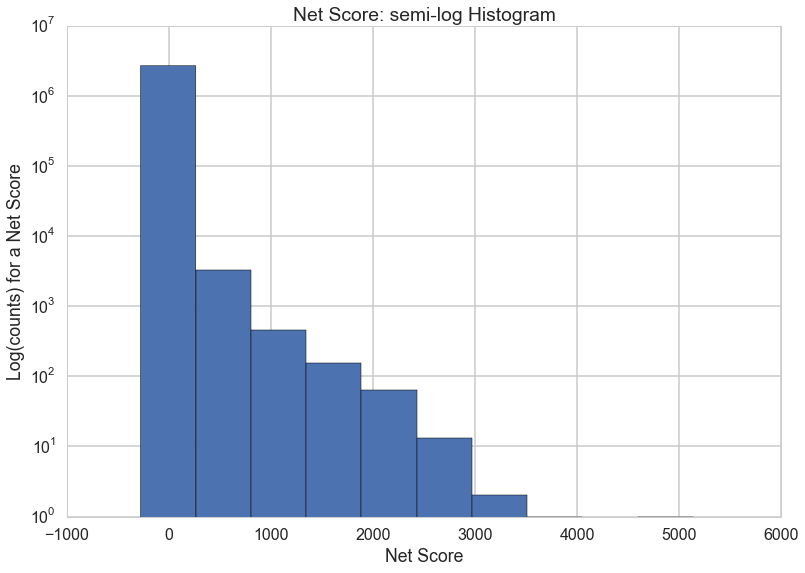

In [17]:
df.score.plot(x = "ups",y = "log(counts)", kind = 'hist',logy = True)
plt.xlabel("Net Score")
plt.ylabel("Log(counts) for a Net Score")

plt.title("Net Score: semi-log Histogram")

Looks like the Net Ups have very very small tails, with the right tail being much heavier than the left.

The semi-log histogram suggested the data was pretty close to 1, but how close?

In [21]:
%%time

d = 0
for i in [-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11]:
    t = sum(df.score == i)
    d = d + t
    print t
print "within domain counts: ",d
print "within domain probability: ",d/2677202.

23198
27769
52707
102826
259217
941117
386611
201335
94959
86248
66713
49822
38801
31021
25435
20683
within domain counts:  2408462
within domain probability:  0.89961907992
CPU times: user 2min 25s, sys: 484 ms, total: 2min 25s
Wall time: 2min 26s


So the spread of the data is very tight.  Anything above 11 or below -4 is outermost 10%-ish, while the range of scores goes as low as -279 and as high as 5135

## Creating new data columns

Before scrapping this data set, I'm going to see about picking apart the comments (and debugging) on this smaller dataset before stressing my computer on a larger dataset.  Namely, I want to know how long the different comments are.  How many words, how many sentences?

In [24]:
# sampling the split on the text in 10 different comments
test = df.body[1:10].apply(lambda x: x.split())
print test

# counting the words in 10 different comments
test.apply(lambda x: len(x))

1    [Yeah,, please, provide, the, quotes, that, sh...
2    [Was, Clinton, any, good, though?, Last, I, re...
3    [What, if, I, told, you, that, both, Democrats...
4                                  [happy, cake, day!]
5    [ISIS, is, that, uprising, in, the, Middle, Ea...
6    [We've, had, a, base, in, Cuba, for, almost, a...
7    [Which, they?, And, how, are, they, enemies, o...
8    [I, am, aware, that, things, cost, money,, gre...
9    [amazing, how, you, misunderstand, my, positio...
Name: body, dtype: object


1    51
2    50
3    48
4     3
5     8
6    37
7    10
8    42
9    45
Name: body, dtype: int64

Using the schema from above in the subsequent cell, we create a new column called "words" which counts the number of words in the body of a comment.

In [25]:
%%time

# split will take the text from the body and break it apart on the space character yielding a bunch of "words."
# These aren't necessarily all words, but it's a pretty good approximation.

# After the split is stored in a list, we count the number of elements in the list
# and return that as the ESTIMATED number of words in the review.

df['words'] = df.body.apply(lambda x: len(x.split()))

CPU times: user 15.9 s, sys: 236 ms, total: 16.2 s
Wall time: 16.1 s


In [26]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3

Run time is surprisingly fast on the word count function.  Next we try and count the number of sentences in each comment.  This will be a bit trickier as we have to pay some attention to context.  Is a period at the end of a sentence, abbreviation, acronym, or some combination of the above?  The function terminal_punc_est() is so named because it is an estimate intended to get close to the actual number of sentences.

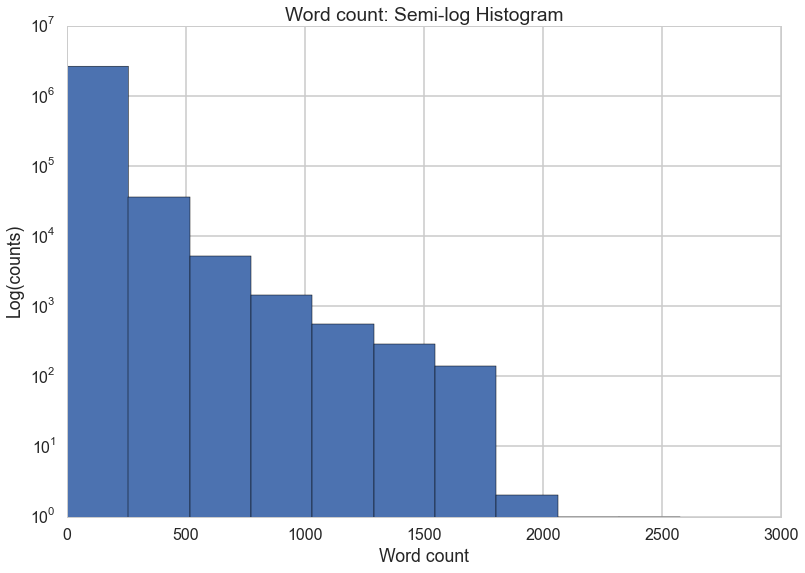

In [33]:
df.words.plot(kind = 'hist',logy = True)

plt.title("Word count: Semi-log Histogram")
plt.xlabel("Word count")
plt.ylabel("Log(counts)")

So the vast majority of comments are short, but still some longer stuff and at least a nover or two to take a look at.  Now for a sentence count:

In [27]:
# checks if a word is an abbreviation or ellipsis.  Can be added to.
def abbrev(word):
    return (word in ['Mr.','mr.','Mrs.','mrs.','Ms.','ms.','...'])
    
# checks if a word has multiple dots, high likelihood of being an acronym
def acronym(word):
    letters = [word.split()]
    dots = 0
    for letter in letters:
        if letter == '.':
            dots = dots + 1
    return dots > 1

# rough estimate of the number of sentences. It's not perfect,
# but it does some error checking for acronyms and abbreviations
def terminal_punc_est(text):
    word_list = text.split()
    terminal_periods = 0
    for entry in word_list:
        if entry[-1] in ['!','?']:
            terminal_periods = terminal_periods + 1
        elif entry[-1] == '.':
            if not abbrev(entry) and not acronym(entry):
                terminal_periods = terminal_periods + 1
            elif entry[-2] =='.':
                terminal_periods = terminal_periods + 1
        elif entry[-2:] == '."':
            terminal_periods = terminal_periods + 1
    return terminal_periods


In [29]:
%%time
df['sentences'] = df.body.apply(terminal_punc_est)

CPU times: user 2min, sys: 1.6 s, total: 2min 2s
Wall time: 2min 1s


Given how many embedded functions have to run and how many more cases need to be managed, I'm surprised this runs as fast as it does.

Like on the smaller dataset, it takes about 8 times as long to run.

In [31]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1

Having taken a newer dataset, the controversiality tag is actually working.  Now let's take a look at what we have and jump into the time consuming steps:

In [32]:
df

author                                               body  controversiality created_utc    link_id  score  words  sentences
0                     gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5
1                 bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3
2                   [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4
3              Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3
4               areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1
5                ikilledtupac          ISIS is that uprising in the Middle East.                 0  1411749550  t3_2hhsq6      1      8          1
6              GetToDaChoppa1  We've had a base in Cuba for almost a century ...                 0  1411400729  t3_2h3e4n      2     37          3
7               sailorbrendan  Which they? And how are they enemies of the st...                 0  1406909859  t3_2cbsek      4     10          2
8                  peedmyself  I am aware that things cost money, great quest...                 0  1405110445  t3_2a1kg8      1     42          2
9            YouReallyThinkSo  amazing how you misunderstand my position, and...                 0  1402691238  t3_27byvg      0     45          0
10                    apeweek  Funny story, Texas was actually lobbying for t...                 0  1414035775  t3_2k0quj     22     33          2
11              thesecretbarn  1. Yes. Those metropolitan districts contain m...                 0  1411690914  t3_2hh2lv      1    170         21
12             Ninjabackwards  /r/conspiracy looks like a great place for you...                 0  1404538716  t3_29p3z1      1     14          3
13                Judg3Smails  Something something shrinking middle class!\n\...                 0  1391452814  t3_1ww0p7      0     29          4
14             Pater-Familias  Ah okay, so single payer was never seriously g...                 0  1405698527  t3_2b120j    -14     83          4
15               UserMCMLXXXV  &gt; No one is out hunting illegals or anythin...                 0  1416539050  t3_2mxl52      2     17          3
16                  darthn3ss  If diesel were cheaper , most Americans would ...                 0  1390045628  t3_1vg7u4      1     32          1
17                      Jrook  You should write a book, or ask your parents f...                 0  1393703245  t3_1z9kxf     -2     14          1
18             shwarma_heaven  Of course paying taxes is patriotic - taxation...                 0  1406210441  t3_2bld7j      5     34          2
19                  [deleted]  Marriage licenses are unconstitutional. Nobody...                 0  1393467371  t3_1z0job     -2     13          2
20                   ristoril  Nothing says "civil discourse" better than the...                 0  1412012756  t3_2hs72b      1     52          2
21               Harbingerx81  I mean in cases like responding to a reported ...                 0  1417196348  t3_2nnww2      2    163          4
22                  [deleted]                                          [deleted]                 0  1393411076  t3_1yyurk      1      1          0
23                   Uriniass  "That's all we do in the Senate is vote on thi...                 0  1409156032  t3_2eqclt    180     72          3
24              Watcher_woman  Can you give me sources on how online voting i...                 0  1416288840  t3_2mj0om      1     34          2
25                davydagger1  the NDAA is what re-authorizes the military, a...                 0  1409418674  t3_2f093v     11    195         13
26               FuckJohnGalt                        Y

Lots of non-ascii characters are going to need to be removed.  And standard end of line or end of row and various other escaped characters need to be handled.

Before I forget, I want to create a variable indicating if a comment is positive or non-positive:

In [34]:
df['positive'] = 1 * (df.score > 0)

In [35]:
# this function counts the number of reply symbols that show up in the comment text
# it isn't an exact of how many pieces of quoted text are replied to, but it's a reasonable
# approximation. (some comments have a termal quote_block symbol)

def reply_count(text):

    # initialize the count
    count = 0
    
    # split text into words
    list_of_words = text.split()

    # for each word, if it begins with 
    for word in list_of_words:
        # apparently if you ask for more letters than the word has, there is no error and you get the entire word.
        if word[:4] == '&gt;':
            count = count + 1
    
    return count

In [36]:
%%time

df['reply_count'] = df.body.map(reply_count)

CPU times: user 42.8 s, sys: 486 ms, total: 43.3 s
Wall time: 43.1 s


That was fast.  If someone knows how to use .loc to make the pink thing go away, please tell me.  I've used the .loc command, but every manner in which I use it just throws a different warning.

Anyway, what does the number of replies look like?

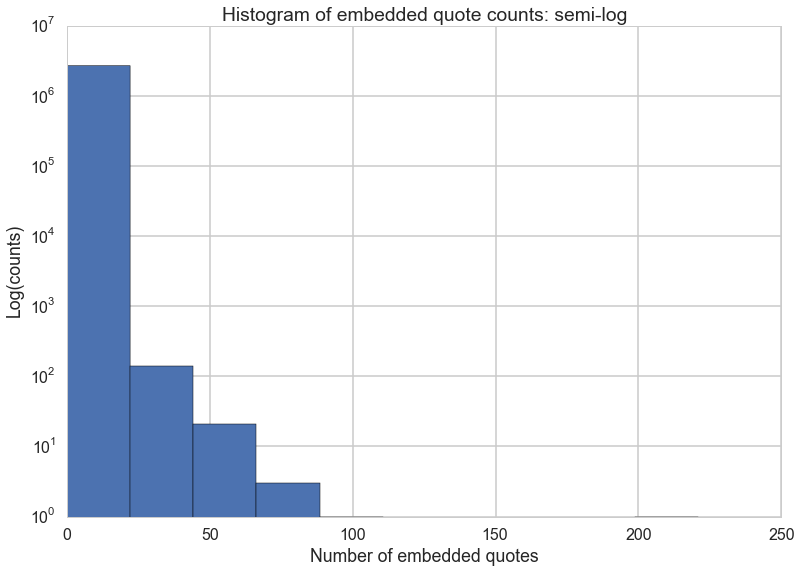

In [37]:
df.reply_count.plot(kind = "hist",logy = True)
plt.title("Histogram of embedded quote counts: semi-log")
plt.ylabel("Log(counts)")
plt.xlabel("Number of embedded quotes")

In [38]:
for i in range(0,20):
    print i, sum(df.reply_count == i)

0 2431819
1 174758
2 35094
3 15745
4 8023
5 4463
6 2343
7 1558
8 919
9 635
10 439
11 323
12 210
13 177
14 144
15 89
16 89
17 54
18 50
19 26


We can see that the vast majority of comments have a small number, if any, of embedded quotes within their text.  This presents a problem I hadn't foreseen where text is being recycled from comment to comment and we are distilling the uniqueness of any given comment.

How to filter out the text of the embedded quotes?  We'll start by looking at what comments with embedded quotes look like.

# NOTE: go back and recount words and sentences after this parsing

In [39]:
test = df.body[df.reply_count == 3]
test.head()

30     &gt; The unions take care of union workers wit...
43     You can't be serious! Bush "just squeaked by" ...
172    &gt; this is one of the most hypocritical stat...
237    &gt;&gt;  There is the money you earn, the mon...
244    &gt; How can you not trust the World Socialist...
Name: body, dtype: object

In [40]:
test = test.reset_index()

In [41]:
test.body[1]

u'You can\'t be serious! Bush "just squeaked by" and what in the hell did that do? A candidate owes his allegiance to his political party and the private interest groups that back it. Anyone incorruptible- such as your Ron Pauls, are gratuitously campaigned against and slandered as "crazy" for whatever personal beliefs the party thinks will STICK with the public so that a wild card won\'t be elected. You want to know what happened to the last wild card that vehemently disavowed private interest groups once in office?  He was fucking assassinated and then his family was picked off. \n\nhttp://www.youtube.com/watch?v=YafZkjiMpjU\n\n&gt;even today, there is little value in ensuring the value of our nation, if our traditions do not survive with it. And there is very grave danger, that an announced need for increased security will be ceased upon by those anxious to expand upon its meaning, to the very limits of official censorship and concealment. That I do not intend to permit to the exten

In [42]:
test.body[2]

u'&gt; this is one of the most hypocritical statements you could have made. Why is it that I cannot force my beliefs on others but others can force their beliefs on me? Same sex marriage does not ONLY affect the lives of the people. It affects everyone. case in point....\n\nAre you seriously comparing being denied the right to marry the consenting adult of your choosing to having to bake a cake in a bakery?\n\nIt also denies death benefits and sometimes the right to be present when your loved ones and family are dying.\n\nLet me explain something, those gay people frequently have jobs and pay taxes which help to fund the infrastructure and utilities that businesses use.  \n\nThis means that businesses benefit from those people.  So part of the contract we have for using society\'s resources is that we don\'t discriminate.  We don\'t deny services because we\'re bigots.\n\n&gt;I would like to see them. Can you please list off hundreds or more of the cases\n\nwww.google.com\n\n1.  So, I 

### Analysis of text

The pattern in most of the cases is that the quoted text goes from the special character '&gt;' to the first \n\n or \r\n.  Then new text flows from then until the next quoted text character (&gt;).  So, as a rough approximation, I should cut out anything between a quoted text character and the subsequent \n\n or \r\n characters.  I think it might be easier to just run from the special character to the \n character and chop that off.  Looking at the above, there is one case where this algorithm appears to falter, but this looks like it gives the right result 90%+ of the time.

I can revisit this if I come up with a better method, although I think a better method at this point will involve actually reading all the comments, which is certainly better, but not time efficient.

In [46]:
# need to read characters into a new character list until "&gt;" shows up,
# then not read until a \n or \r, then start reading again

def strip_replies(text):
    # initialize the return text
    clean_text = ""
    
    # variable assignment of the odd characters to prevent retyping
    quote_block = "&gt;"
    
    # noting the length of the text so I don't overshoot the array
    # of characters and create an error from an invalid read
    text_length = len(text)
    
    # initializing where in the text string we are
    i = 0
    
    # this loop will run from the beginning to end of a piece of text stripping out text
    # that appears after the 
    while i in range(0,text_length):

        # if we identify embedded quotes, skip that character and start cutting text
        if text[i:i+4] == quote_block:
            i = i + 4
            next_char = " "
            
            # if we have stumbled upon a quote block, this will effectively cut out all of
            # the text between the quote block and the next \n or \r character, which is
            # a reasonable approximation of the quotes
            while next_char not in ['\n','\r']:
                if i == text_length:
                    break
                next_char = text[i]
                i = i + 1

        # if we're not in embedded text, keep it for final output
        else:
            clean_text = clean_text + text[i]
            i = i + 1
            
    # return the comment sans embedded text
    return clean_text
            

In [47]:
test_sample = test.body[4]
strip_replies(test_sample)

u"\nAfter the lies told by the NYT in the run-up to the Iraq war, how could you trust the NYT?\n\nNo source is perfect. One has to use/read multiple sources of information to detect the spin that sources put in their news articles. I trust the WSWS in most cases because they offer perspectives based on a realistic view of events, instead of the nationalistic view that we get by default in the US corporate mass media.\n\n\nSort of like the US did in Iraq, Afghanistan and Kosovo?\n\n\nLet's see, why would non-Russians in the Crimea vote to joint Russia, the country that they have been a part of for *centuries*, instead of choosing to stay with Ukraine, a near-bankrupt country with only a 20-odd year history of being a country, a country which just had a foreign-funded coup d'etat against a democratically-elected government, a country which is much poorer than Russia, and with them choosing to vote to stay in a government which is the first in Europe since WWII to have outright fascists i

In [48]:
test_sample

u"&gt; How can you not trust the World Socialist Web Site?\n\nAfter the lies told by the NYT in the run-up to the Iraq war, how could you trust the NYT?\n\nNo source is perfect. One has to use/read multiple sources of information to detect the spin that sources put in their news articles. I trust the WSWS in most cases because they offer perspectives based on a realistic view of events, instead of the nationalistic view that we get by default in the US corporate mass media.\n\n&gt; Or a snap election, under military occupation, called for by a government instilled by said occupier?\n\nSort of like the US did in Iraq, Afghanistan and Kosovo?\n\n&gt; If 97% of Crimeans voted to join Russia, why wouldn't you believe them? It's not as though a quarter are Ukrainians, and a quarter are pro-Ukraine Tatars, right?\n\nLet's see, why would non-Russians in the Crimea vote to joint Russia, the country that they have been a part of for *centuries*, instead of choosing to stay with Ukraine, a near-

It appears that we have a function that reliably strips out our quoted blocks.  How quickly does this run?

In [55]:
df_parse = df.loc[(df.reply_count > 0),['body']]
df_parse

body
15       \nWellll.....  \n\nBut I meant relatives abroa...
25       the NDAA is what re-authorizes the military, a...
30       \nI'll need more that your little canard on th...
43       You can't be serious! Bush "just squeaked by" ...
48         \nThat's a ridiculous argument.  It hinges o...
57       \nWhy? Isn't USA "The Greatest Country On Eart...
95       \n\n\nYou'll have to get some stats on that on...
118      \nThe conservative idea of "melting pot" means...
129      \nEasily huh?  If this was so why don't all th...
131      Wait! Wait a second! Hold on to your horses!  ...
147      \n"Independent" person or whatever, please sub...
164      \nOn the other hand is it right for us to foot...
172      \nAre you seriously comparing being denied the...
193      \nWhich votes are he scheming for, four more y...
195      Fear to being children into the world"\n      ...
196      \nSince 1880 the average temperature has risen...
199      \ni don't think that is the case. i'm pretty s...
217      \nThat's the point I'm trying to make. There w...
230                                                       
237      \n\nOK, what are the other sources?  Money doe...
242      As a Missourian, I'm thoroughly pissed at this...
244      \nAfter the lies told by the NYT in the run-up...
248      \nYou realize that you just admitted you are O...
302      \nThat's where the lines become blurred. Guns ...
317      The first time I read about it was [an article...
321      \nThat's the plan. \n\n"I don't want to abolis...
337      \n - So, you are willing not to have any oblig...
363      \nBingo. UPMC is the largest company here in P...
378                      \nDeath sentences not included.\n
379      \nI don't know for sure, but I hope that this ...
...                                                    ...
2676756  &gt;Personally...\n\nDoesn't matter in the sli...
2676760  &gt; the angst is rising on Capitol Hill\n\nTh...
2676786  Well when the states collapse, and crypto curr...
2676806  &gt;Do you honestly think that handing about $...
2676809  &gt;SO much edge\n\nthat's ironic, given what ...
2676834  I guess we disagree, then. I believe that both...
2676835  That's when you automatically start cutting sp...
2676845  &gt;The purpose of it [simulated drowning, mal...
2676850  &gt;The OSHA inspections still happened, the c...
2676860  Correlation is never cause, it's just correlat...
2676871  &gt; you realize Al Gore ran a campaign on goi...
2676888  &gt;The unemployment rate is at 6%, two years ...
2676899  &gt;  Looking through that seems a bit off to ...
2676901  &gt;This prevents abuse of this religious exem...
2676941  &gt;I disagree. They deserve justice, not a ly...
2676950  &gt; People who understand politics know that ...
2676976  &gt;You don't understand that any reasonable p...
2676985  &gt; chemical dependency \n\nCannot happen wit...
2676993  &gt;I blame Obama for creating the atmosphere ...
2677003  &gt; Here are the private companies that own t...
2677019  &gt;There was no vigilante mission \n\n&gt; Af...
2677026  &gt; That's not how war works. It just isn't. ...
2677034  &gt;If there was no external entity, then it w...
2677063  &gt; I don't know if that is the most apt issu...
2677067  &gt;Pure research labs in corporations are als...
2677089  &gt; Conservative != fascist\n\nThen perhaps y...
2677132  &gt;Saying that an ultra rich person and their...
2677167  &gt; If there weren’t government programs, it ...
2677172  &gt; we should be praising him for a job well ...
2677193  &gt;Over here in Bakersfield, CA, there was ON...

[245383 rows x 1 columns]

In [56]:
%%time
df_parsed = df_parse.applymap(strip_replies)

CPU times: user 2h 24min 27s, sys: 1min 31s, total: 2h 25min 59s
Wall time: 2h 24min 42s


In [57]:
%%time
df.loc[df_parsed.index,df_parsed.columns] = df_parsed

CPU times: user 402 ms, sys: 86.4 ms, total: 488 ms
Wall time: 486 ms


I really wanted to find an effcient way to do this.  This seems relatively straightforward, but I feel like there should have been something faster.

If anyone reads this and has a faster blurb of code to pass on, I'd love to see it.

# Since this took forever, I'm going to save the data and pick up here.

In [58]:
df.to_pickle('df2014a.pkl')

In [59]:
# Restore the data

df = pd.read_pickle('df2014a.pkl')
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0

In [61]:
%%time

# re-running the word and sentence counts now that the embedded quotes have been pruned

df['words'] = df.body.apply(lambda x: len(x.split()))
df['sentences'] = df.body.apply(terminal_punc_est)

CPU times: user 1min 54s, sys: 7.35 s, total: 2min 1s
Wall time: 1min 56s


In [62]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0

Still want a column indicating question marks, a column indicating exclamation marks, and a column indicating hyperlinks.

In [63]:
#multi-purpose function intended to count punctuation

def count_symbol(text,symbol):
    count = 0
    length = len(text)
    
    for i in range(length):
        if text[i] == symbol:
            count = count + 1
    return count

In [64]:
df.body[1]

u"Yeah, please provide the quotes that show that he thought gay marriage would lead to phedophilia and beastiality.\n\nOr are we just talking about someone saying that he didn't want to be defined as a single-value politician and so would leave to others to lead.\n\nBecause the two are *vastly* different."

In [65]:
print (count_symbol(df.body[1],'.'), 
       count_symbol(df.body[1],'?'), 
       count_symbol(df.body[1],'!'), 
       count_symbol(df.body[1],'e'))

(3, 0, 0, 31)


Looks like the function is working.  Let's apply it to the entire series of comments.

In [66]:
%%time

df['question'] = df.body.map(lambda x:count_symbol(x,'?'))
df['exclamation'] = df.body.map(lambda x:count_symbol(x,'!'))

CPU times: user 4min 23s, sys: 8.11 s, total: 4min 31s
Wall time: 4min 25s


In [67]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count  question  exclamation
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0         1            1
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0         0            0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0         1            0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0         1            0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0         0            1

In [68]:
df.body[3]

u"What if I told you that both Democrats and Republicans are in collusion to disrupt the balance we have in place for personal gain and to allow greed to flourish? Lets be realistic here.. It is foolish to think either party has the people's best intrest in mind. "

Terrific.  Questions and Exclamations counted.  Time to move on to hyperlinks

In [69]:
def count_symbol_generic(text,symbol):
    count = 0
    length = len(text)
    s_length = len(symbol)
    for i in range(length):
        if text[i:i+s_length] == symbol:
            count = count + 1
    return count

In [110]:
df.body[44]

u'That\'s the slogan of most teacher\'s unions "We have no responsibility to provide a quality public education."\n\nSeriously, WTF is it with the teachers.  They can\'t teach these kids?  Why the hell would they cash a paycheck, or be allowed to cash a paycheck.  Seriously, what do they say?  Do they say, "blame them not me?"\n\nWhat the double fuck, $20K per student?  http://www.michigancapitolconfidential.com/18520\n\nhttp://en.wikipedia.org/wiki/Highland_Park_Public_Schools\n\n\nPrivate schools in my area cost 5-7k for grammar school and 10-12K for high school - in some buildings that are 75 - 100 years old.'

In [112]:
count_symbol_generic(df.body[44],'http')

2

Seems to be working.  Now to do the entire dataframe.

In [113]:
%%time

df['hyperlinks'] = df.body.map(lambda x:count_symbol_generic(x,'http'))

CPU times: user 2min 53s, sys: 5.31 s, total: 2min 58s
Wall time: 2min 54s


In [114]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count  question  exclamation  hyperlinks
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0         1            1           0
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0         0            0           0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0         1            0           0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0         1            0           0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0         0            1           0

In [115]:
df.to_pickle('df2014b.pkl')

# Can pick up here without re-running the entire notebook

In [2]:
# if you broke things again and need to restart the kernel, ... well, start here!

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud
import re
import unicodedata

In [116]:
# Restore the data

# df = pd.read_pickle('df2014b.pkl')

# Make a dictionary!

Make all the letters small and assemble a dictionary!  In truth, this should have been done way back at the beginning, although, I'm not sure it really matters that much since I haven't used the actual words just yet.

This has gone through several iterations.  What I have now does a pretty good job of taking out hyperlinks and unrelated punctuation and characters.  Unicode is turned into ascii and processed.

There are a few special cases that are still showing up.  I don't take out hyphens because more often than not, they are meaningful.  That said, I need to take out leading hyphens, and leading and trailing apostrophes (internal apostrophes are usually contractions or otherwise meaningful to words.

In [117]:
# take the data

df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count  question  exclamation  hyperlinks
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0         1            1           0
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0         0            0           0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0         1            0           0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0         1            0           0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0         0            1           0

In [159]:
%%time

# first we turn the unicode into ascii for easier processing
temp = df.body.map(lambda x: ud.unidecode(x))

# split the data strings into lists of strings
list_of_list_of_words = temp.map(lambda x: x.split())

NameError: name 'x' is not defined

In [172]:
%%time

temp2 = temp.apply(lambda x: x.encode('ascii','ignore'))

CPU times: user 7.23 s, sys: 5.89 s, total: 13.1 s
Wall time: 13.3 s


In [ ]:
temp2

In [176]:
list_of_list_of_words = temp2.map(lambda x: x.split())

In [177]:
# this function checks for hyperlinks and, if found, replaces the entire 'word' with ''.

def strip_word(text,identifier):
    
    # variable assignment of the letters prevent retyping
    block = identifier
    block_length = len(block)
    # noting the length of the text so I don't overshoot the array
    # of characters and create an error from an invalid read
    text_length = len(text)

    i = 0
    while i in range(0,text_length-block_length):

        # if we identify a hyperlink:
        if text[i:i+block_length] == block:
            
            #return nothing
            return ""
        i = i + 1
        
    return text

# this function can be used in conjunction with the above to strip out the hyperlink words.

def shorten_list(list):
    
    words = []

    for i in list:
        if i != '':
            words.append(i)
            
    return words

In [178]:
%%time

temp_list_of_list_of_words = [shorten_list([strip_word(i,'http') for i in j]) for j in list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'www') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.com') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.gov') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.html') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.htm') for i in j]) for j in temp_list_of_list_of_words]

CPU times: user 30min 35s, sys: 1min 23s, total: 31min 59s
Wall time: 32min 6s


In [179]:
temp_list_of_list_of_words[28]

['Well',
 'the',
 'Dems',
 'should',
 'reform',
 'to',
 'be',
 'liberal,',
 'rather',
 'than',
 'dreaming',
 'of',
 'the',
 'elimination',
 'of',
 'the',
 'GOP,',
 'starting',
 'a',
 'new',
 'leftist',
 'party',
 'and',
 'leaving',
 'the',
 'Dems',
 'to',
 'the',
 'conservatives.',
 'Anyway',
 'with',
 'the',
 'nature',
 'of',
 'our',
 'national',
 'political',
 'system,',
 'funding',
 'structures,',
 'generations',
 'of',
 'party',
 'faithful,',
 'etc.',
 'neither',
 'party',
 'is',
 'going',
 'anywhere,',
 'for',
 'better',
 'or',
 'for',
 'worse.']

If that worked, now we'll rejoin things, edit out the unicode, make substitutions, and resplit.

In [16]:
def join_up(list_of_words):
    text = ""
    for word in list_of_words:
        text = text + " " + word
    return text

In [181]:
join_up(temp_list_of_list_of_words[28])

' Well the Dems should reform to be liberal, rather than dreaming of the elimination of the GOP, starting a new leftist party and leaving the Dems to the conservatives. Anyway with the nature of our national political system, funding structures, generations of party faithful, etc. neither party is going anywhere, for better or for worse.'

In [182]:
%%time

temp_list_strings = [join_up(i).lower() for i in temp_list_of_list_of_words] 

CPU times: user 40.6 s, sys: 5.6 s, total: 46.2 s
Wall time: 46 s


In [183]:
df.body = temp_list_strings

In [3]:
%%time

# Another good checkpoint

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud

# Restore the data
#df = df.to_pickle('df2014c.pkl')
df = pd.read_pickle('df2014c.pkl')
#df.head()

CPU times: user 14.6 s, sys: 2.07 s, total: 16.6 s
Wall time: 17.5 s


In [4]:
%%time

df.body = df.body.map(lambda x: x.lower())

CPU times: user 10.7 s, sys: 876 ms, total: 11.6 s
Wall time: 11.5 s


In [5]:
%%time

df.body = df.body.map(lambda x: (x.replace('?',' ')
                                .replace(',',' ')
                                .replace('.',' ')
                                .replace(':',' ')
                                .replace(';',' ')
                                .replace('!',' ')))

CPU times: user 6.74 s, sys: 599 ms, total: 7.34 s
Wall time: 7.25 s


In [6]:
%%time

df.body = df.body.map(lambda x: (x.replace('"',' ')
                                .replace('(',' ')
                                .replace(')',' ')
                                .replace('[',' ')
                                .replace(']',' ')))

CPU times: user 4.79 s, sys: 90.6 ms, total: 4.88 s
Wall time: 4.86 s


In [7]:
%%time

df.body = df.body.map(lambda x: (x.replace('--',' ')
                                .replace('/',' ')
                                .replace('=',' ')
                                .replace('*',' ')
                                .replace('_',' ')))

CPU times: user 5.55 s, sys: 104 ms, total: 5.66 s
Wall time: 5.6 s


In [8]:
%%time

df.body = df.body.map(lambda x: (x.replace('^',' ')
                                .replace('~',' ')
                                .replace('|',' ')
                                .replace('`',' ')
                                .replace('{',' ')
                                .replace('}',' ')))

CPU times: user 5.23 s, sys: 102 ms, total: 5.33 s
Wall time: 5.27 s


In [207]:
%%time

df.body = df.body.map(lambda x: (x.replace('\\',' ')
                                .replace('&amp','&')
                                .replace('&gt',' ')
                                .replace('&lt',' ')))

CPU times: user 7.45 s, sys: 174 ms, total: 7.63 s
Wall time: 7.52 s


In [9]:
%%time

df.body = df.body.map(lambda x: (x.replace('\x01',' ')
                                .replace('\x04','&')
                                .replace('\x07',' ')
                                .replace('\x10',' ')
                                .replace('\x18',' ')
                                .replace('\x19',' ')
                                .replace('\x0e',' ')))

CPU times: user 6.36 s, sys: 176 ms, total: 6.54 s
Wall time: 6.42 s


In [10]:
df.body[1]

" yeah  please provide the quotes that show that he thought gay marriage would lead to phedophilia and beastiality  or are we just talking about someone saying that he didn't want to be defined as a single-value politician and so would leave to others to lead  because the two are  vastly  different "

In [11]:
%%time

list_of_list_of_words = df.body.map(lambda x: x.split())

CPU times: user 22.8 s, sys: 12.6 s, total: 35.4 s
Wall time: 35 s


In [12]:
%%time

# Stripping out leading and trailing hyphens and quotes I couldn't just replace out like other punctuation

# new list of list of words.
nlolow = []

index = 0
for list_of_words in list_of_list_of_words:
    low = []
    for word in list_of_words:
        sub = word
        if len(sub)!=1:
            if sub[-1] in ["'","-","+"]:
                sub = sub[0:-1]
            if sub[0] in ['-',"'"]:
                sub = sub[1:]
        if sub not in ['-','\'',""]:
            low = low + [sub]
    nlolow.append(low)
    

CPU times: user 3min 1s, sys: 5.46 s, total: 3min 6s
Wall time: 3min 4s


In [13]:
len(nlolow),len(list_of_list_of_words)

(2677202, 2677202)

In [14]:
%%time

word_dict = {}

for list_of_words in nlolow:
    for word in list_of_words:
        if not word in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1

CPU times: user 45.9 s, sys: 436 ms, total: 46.4 s
Wall time: 46.1 s


In [214]:
word_dict

{'opensecrests': 1,
 'equipment-wise': 1,
 'bean-stalk': 1,
 'reddit-browsing': 1,
 'bloothbath': 1,
 'bicamerial': 1,
 'sowell': 176,
 'utnapishtim': 2,
 'scientologist-run': 1,
 'mobillity': 1,
 'fleeces': 3,
 'kritt': 1,
 'woods': 698,
 'clotted': 2,
 'spiders': 61,
 'alsewhere': 1,
 'ultimatley': 3,
 'woody': 71,
 'trawling': 23,
 'jonser': 1,
 'comically': 195,
 'mdbx': 2,
 '250k-300k': 2,
 'reallocations': 1,
 'regularize': 3,
 "andr50's": 1,
 'caner': 4,
 'canes': 12,
 'reaslistic': 1,
 'cosmicsans': 1,
 "'facility'": 1,
 'sprague': 2,
 'brockton': 6,
 'jairam': 1,
 'acurately': 2,
 'accrew': 1,
 'theoreticals': 7,
 'mooded': 1,
 'pre-judgmental': 2,
 'hsw': 1,
 'buy-here': 2,
 'caned': 3,
 'fundation': 2,
 'atrophying': 2,
 'vann': 6,
 'denmarkian': 1,
 'canem': 1,
 'government-to-government': 1,
 'second-oldest': 1,
 'famiies': 1,
 'slothful': 5,
 'naturopathic': 3,
 'hisasue': 1,
 'neonnights': 1,
 'veto-override': 1,
 'gasoline-fueled': 1,
 'pigment': 17,
 'ididthemeth': 1,


Ok, I'm pretty happy with this dictionary.  If you find more things in here that you think I can filter out, let me know.

I will say, at this point, it will take quite some time to get past the first checkpoint where I edit out the embedded quotes, so hopefully changes occur after that, not before.

In [215]:
test = word_dict.keys()

In [216]:
len(test)

328475

In [217]:
test.sort()
print test

['\x01', '\x04', '\x07georgia', '\x0eof', '\x10', '\x18', '\x18\x18', '\x190', '#', '##', '###', '####', '#####', '######', '#######', '########', '#########', '###########', '############', '################', '#########################+++++++++++####', '#######################+++++++##+++++###', '######################++++++###########', '######################++++++++##########', '######################+++++++++#########', '######################+++++++++++#######', '#####################+++++++++++########', '###################+####+++####++++++###', '###################+++++########+++++++#', '###################++++++#########++++##', '###################++++++++++++##+#++###', '###################+++++++++++++++++++##', '##################+++##+#####+++++++####', '##################++++++++++++++++######', '##################++++++++++++++++++++##', '################+++++++++++++++++++#####', '###############++++++++#####+++++++#++##', '########++######++++++####+++++++++++++#'

So, take a look at the above.  I don't think we can do a much better job of filtering out bad text.  I got a few percent gain tonight on correctly diagnosing words.  I think further work is going to be for tenths of a percent or less, and for "words" that probably are very infrequent.


In [17]:
for_storage = [join_up(i) for i in nlolow] 
df.body = for_storage
df.to_pickle('df2014d.pk1')

# We can pick up here now :-)

In [5]:
# if you broke things again and need to restart the kernel, ... well, start here!

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud

df = pd.read_pickle('df2014d.pkl')

In [9]:
df.head()

author                                               body   link_id        name  score  words  sentences  positive  reply_count  question  exclamation  hyperlinks
0     quiller  [assuming, that, isn't, a, rhetorical, questio...  t3_63k3x  t1_c02q0jn      1     47          2         1            0         0            0           0
1   [deleted]  [several, more, fallacies, keep, piling, them,...  t3_63klz  t1_c02q0jo      2      7          2         1            0         0            0           0
2   [deleted]                      [the, silence, is, deafening]  t3_63klz  t1_c02q0jr      3      4          1         1            0         0            0           0
3  malcontent  [you, must, be, one, of, those, guys, who, is,...  t3_63j16  t1_c02q0jw      1     56          4         1            0         2            0           0
4  Greengages  [don't, worry, america, it's, a, simple, opera...  t3_63kxs  t1_c02q0jy      2     29          3         1            0         0            0           0